### Import the required modules and libraries

In [107]:
from PIL import Image
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms
import skimage

In [ ]:
'''
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--image', required=True, help='path to image')
args = parser.parse_args()
'''

### Accessing all the convolutional layers and weights

In [109]:
model = models.resnet18(weights="DEFAULT")
model_children = list(model.children())

model_weights = []
model_layers = []

for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        model_weights.append(model_children[i].weight)
        model_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    model_weights.append(child.weight)
                    model_layers.append(child)

print("Total convolution layers: {}".format(len(model_layers)))
# for weight, conv in zip(model_weights, model_layers):
#     print("Conv: {} -> shape: {}".format(conv, weight.shape))

Total convolution layers: 17


In [110]:
weights = []
for weight in model_weights:
    filter = torch.sum(weight, 1)
    filter /= filter.shape[0]
    weights.append(filter)
    print(filter.shape)

torch.Size([64, 7, 7])
torch.Size([64, 3, 3])
torch.Size([64, 3, 3])
torch.Size([64, 3, 3])
torch.Size([64, 3, 3])
torch.Size([128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([128, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([512, 3, 3])
torch.Size([512, 3, 3])
torch.Size([512, 3, 3])
torch.Size([512, 3, 3])


### Visualize convolutional layer filters
For simplicity, here only visualize the filters of the first convolutional layer.

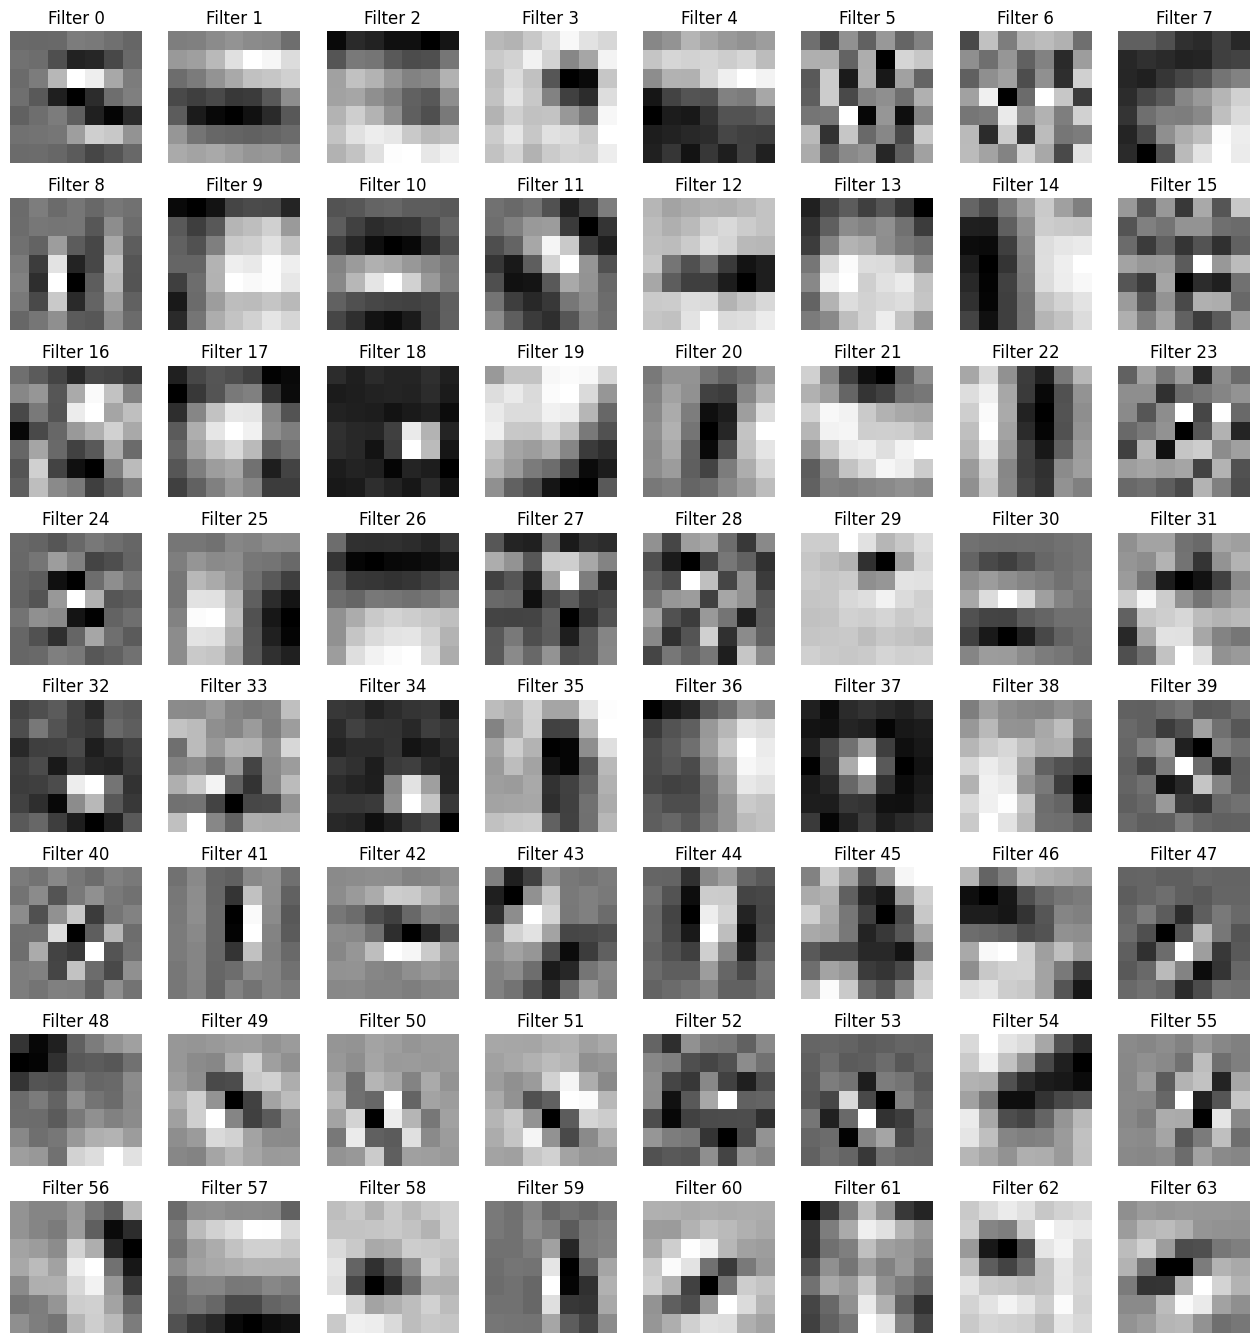

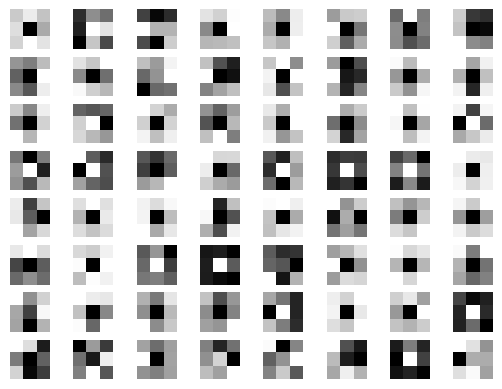

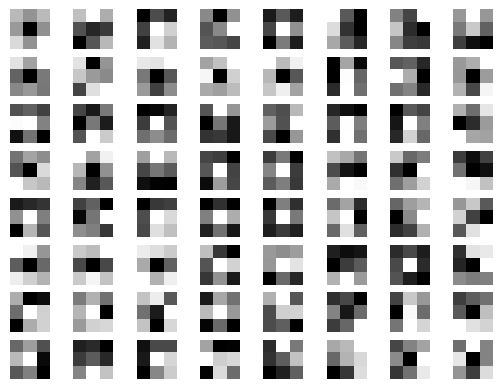

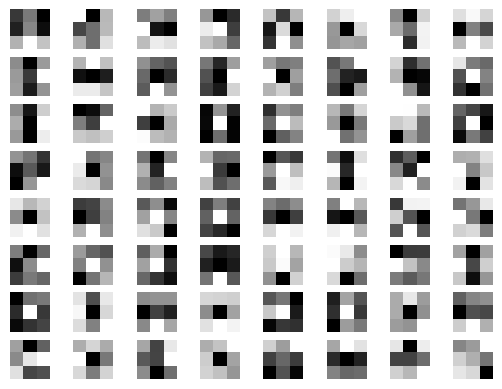

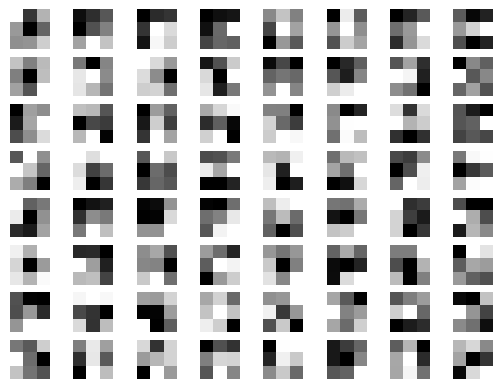

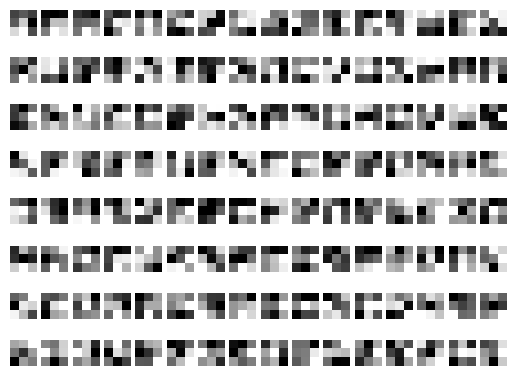

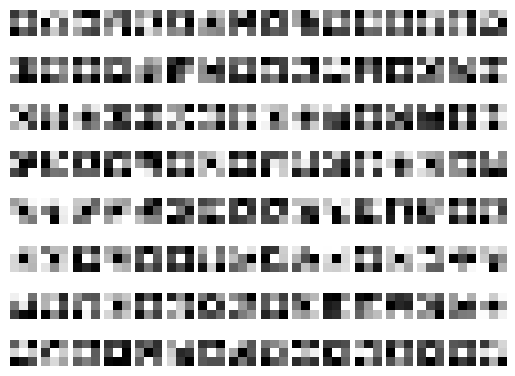

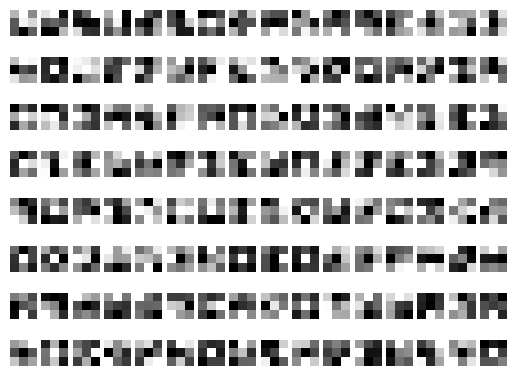

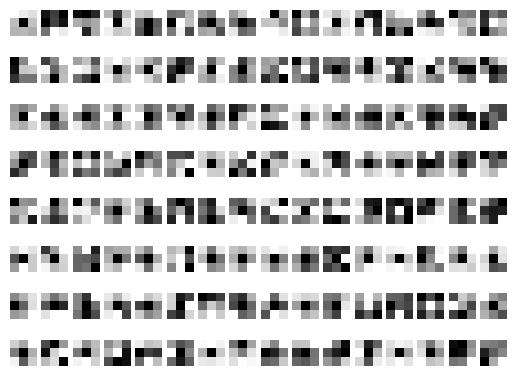

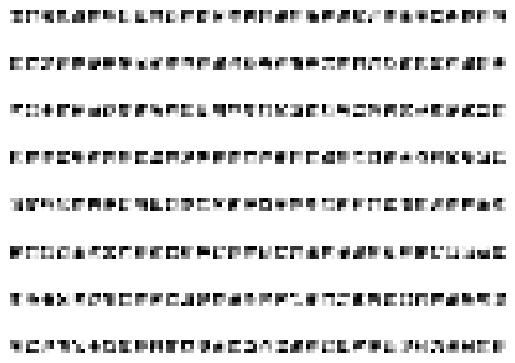

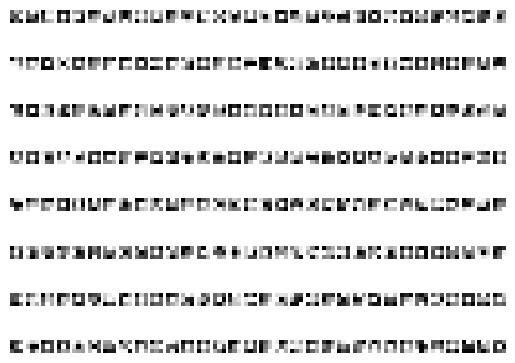

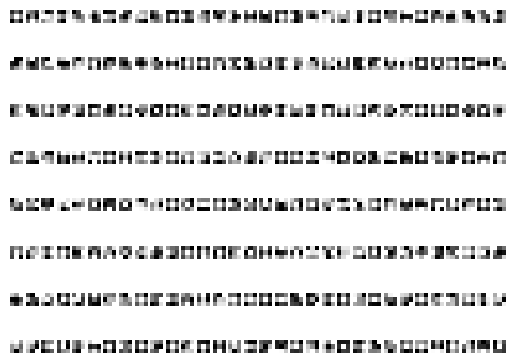

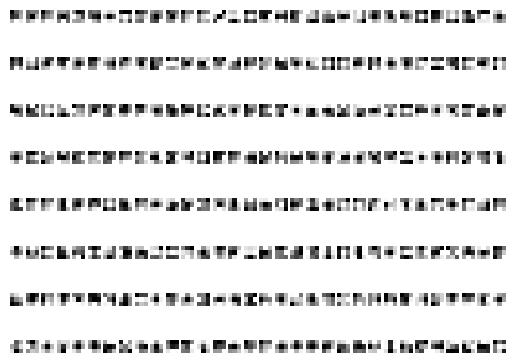

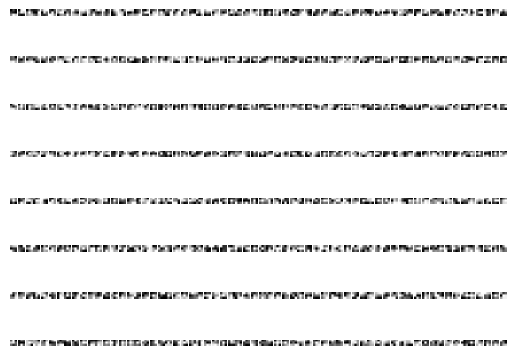

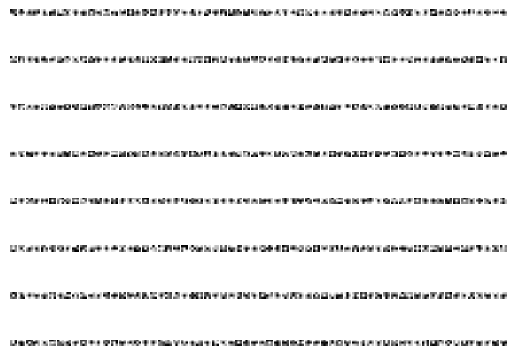

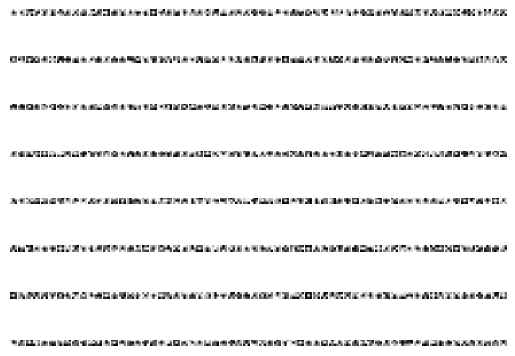

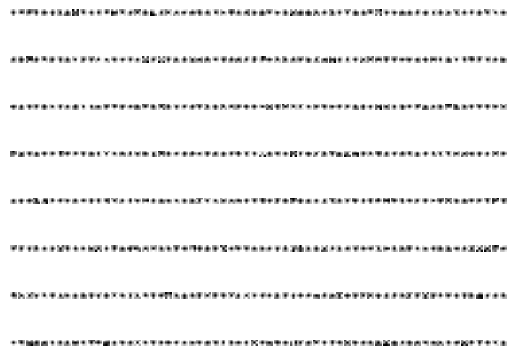

In [136]:
plt.figure(figsize=(16, 17))
for idx, filter in enumerate(weights[0]):
    plt.subplot(8, 8, idx+1)
    plt.title('Filter ' + str(idx))
    plt.imshow(filter.detach(), cmap='gray')
    plt.axis('off')
plt.savefig('./output/filter_0.png')
plt.show()

for num_layer, weight in enumerate(weights[1:]):
    plt.figure()
    for idx, filter in enumerate(weight):
        plt.subplot(8, int(weight.shape[0]/8), idx+1)
        plt.imshow(filter.detach(), cmap='gray')
        plt.axis('off')
    plt.savefig('./output/filter_' + str(num_layer+1) + '.png')
plt.show()


### Visualize feature maps

Simply process image through every layer and store them in outputs[] and names[] list

##### Load image

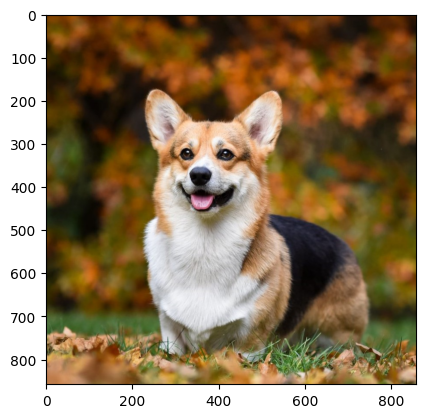

In [112]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

image = Image.open('./src/corgi.jpg')
plt.imshow(image)

##### Transforms image

In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

image = transform(image)
image = image.unsqueeze(0)
image = image.to(device)

##### Generate feature maps

In [114]:
feature_maps = []
names = []

img = image
for layer in model_layers:
    img = layer(img)
    feature_maps.append(img)
    names.append(str(layer))
    # print('Feature map shape: {}'.format(img.shape))
print('Total feature maps: {}\n'.format(len(feature_maps)))

outputs = []
for feature_map in feature_maps:
    feature_map = feature_map.squeeze(0)
    combination = torch.sum(feature_map, 0)
    combination /= feature_map.shape[0]

    outputs.append(combination.data.cpu().numpy())
    print('Feature map shape: {}'.format(combination.shape))
    

Total feature maps: 17

Feature map shape: torch.Size([112, 112])
Feature map shape: torch.Size([112, 112])
Feature map shape: torch.Size([112, 112])
Feature map shape: torch.Size([112, 112])
Feature map shape: torch.Size([112, 112])
Feature map shape: torch.Size([56, 56])
Feature map shape: torch.Size([56, 56])
Feature map shape: torch.Size([56, 56])
Feature map shape: torch.Size([56, 56])
Feature map shape: torch.Size([28, 28])
Feature map shape: torch.Size([28, 28])
Feature map shape: torch.Size([28, 28])
Feature map shape: torch.Size([28, 28])
Feature map shape: torch.Size([14, 14])
Feature map shape: torch.Size([14, 14])
Feature map shape: torch.Size([14, 14])
Feature map shape: torch.Size([14, 14])


##### Plot each feature map of the first layer

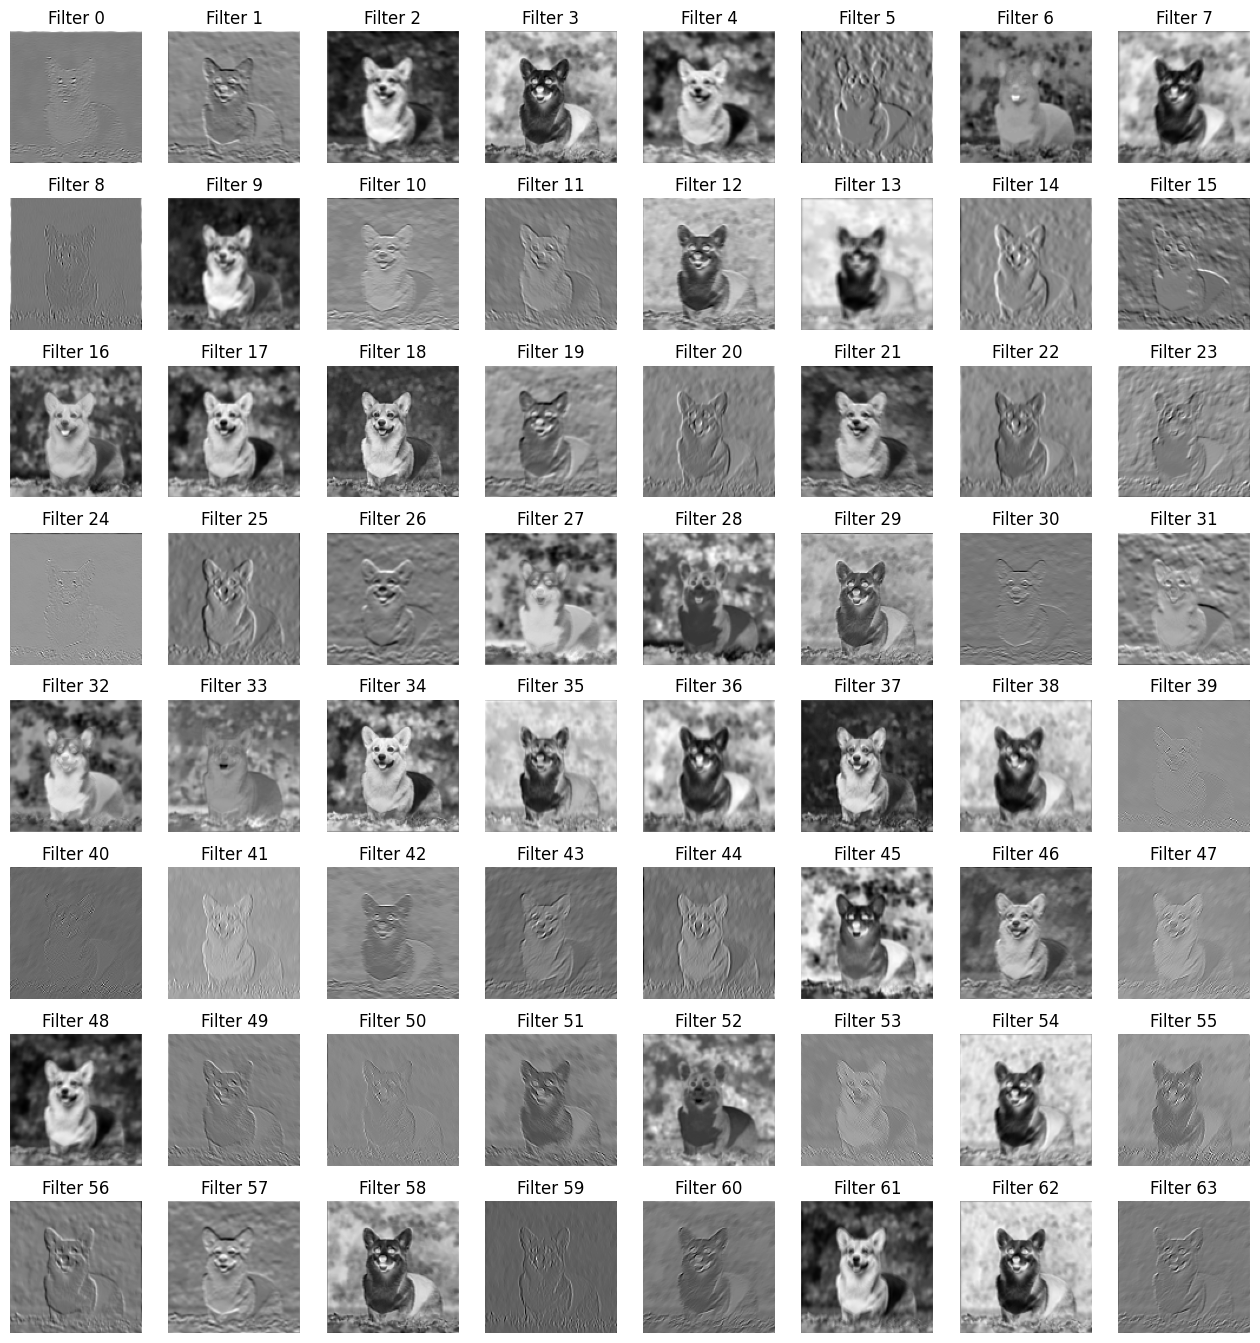

In [137]:
num_layer = 0
fm = feature_maps[num_layer].squeeze(0).cpu()

plt.figure(figsize=(16, 17))
for i in range(len(fm)):
    plt.subplot(8, 8, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(fm[i].detach(), cmap='gray')
    plt.axis('off')
plt.show()

##### Plot output feature maps of each layer

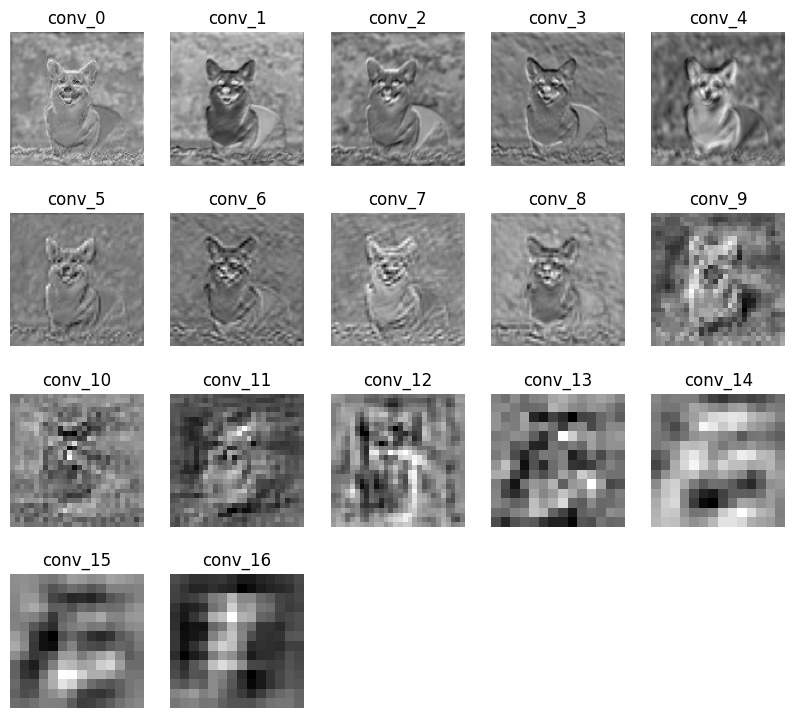

In [138]:
plt.figure(figsize=(10, 9))
for i in range(len(outputs)):
    plt.subplot(4, 5, i+1)
    plt.title('conv_' + str(i))
    plt.imshow(outputs[i], cmap='gray')
    plt.axis('off')
plt.savefig('./output/featue_map.png')
plt.show()